## Notebook Purpose and Summary

This notebook processes multiples csv files and perform polynomial detrending.

In [2]:
# import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

from scipy.stats import skew, kurtosis
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import find_peaks, savgol_filter 
from scipy.ndimage import uniform_filter1d
from sklearn.metrics import mean_squared_error



from astropy.stats import median_absolute_deviation as MAD


In [3]:
# #plots layout
from matplotlib import rc
# from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.font_manager
import matplotlib.colors as colors


plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 18


SMALL_SIZE = 15
MEDIUM_SIZE = 17
BIGGER_SIZE = 19

plt.rc('font', size=SMALL_SIZE)          # controls default text
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)


In [4]:
# read clean data and drop missing values
folder = "Data/Data_cleaned"  # path for folder
files = glob.glob(os.path.join(folder, "*.csv"))

# Dictionary to store each instrument's data
dataframe_clean = {}
labels = []

for file in files:
    # Get file base name without extension (e.g., camera, radio)
    label = os.path.splitext(os.path.basename(file))[0]
    labels.append(label)

    
    # Load CSV into a DataFrame
    df = pd.read_csv(file)
    
    #drop any row with missing values in this file only
    df = df.dropna().reset_index(drop=True)


    # # Store in the dictionary
    dataframe_clean[label] = df

dataframe_clean

{'Kiricom_Radio_On_MAX_100kHz_EIRP':        Unnamed: 0  Frequency (MHz)  Clean_EIRP(dBm)
 0               0          80.0925       -59.478259
 1               1          80.1850       -61.157473
 2               2          80.2775       -61.318212
 3               3          80.3700       -60.994273
 4               4          80.4625       -61.422765
 ...           ...              ...              ...
 12797       21291        2049.5100       -87.196076
 12798       21292        2049.6025       -84.371832
 12799       21294        2049.7875       -86.330525
 12800       21295        2049.8800       -94.942077
 12801       21296        2049.9725       -92.431921
 
 [12802 rows x 3 columns],
 'Superfire_HL58_Headlamp_100kHz_EIRP':        Unnamed: 0  Frequency (MHz)  Clean_EIRP(dBm)
 0               1          80.0925      -105.448569
 1               2          80.1850      -129.491156
 2               5          80.4625       -98.770357
 3               6          80.5550       -93.65

/tmp/ipykernel_4324/74398120.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


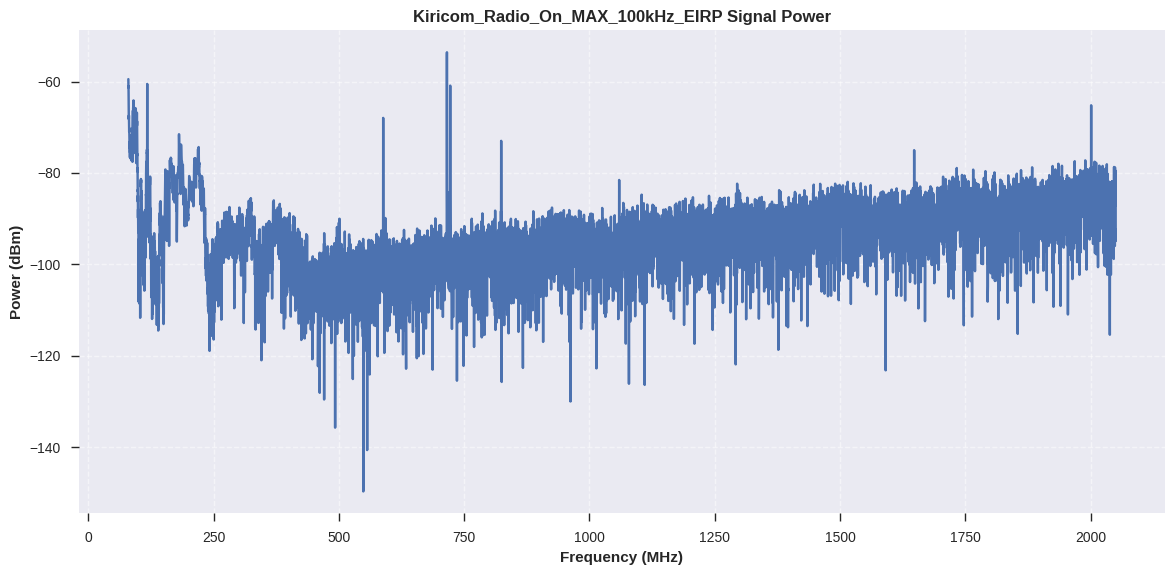

/tmp/ipykernel_4324/74398120.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


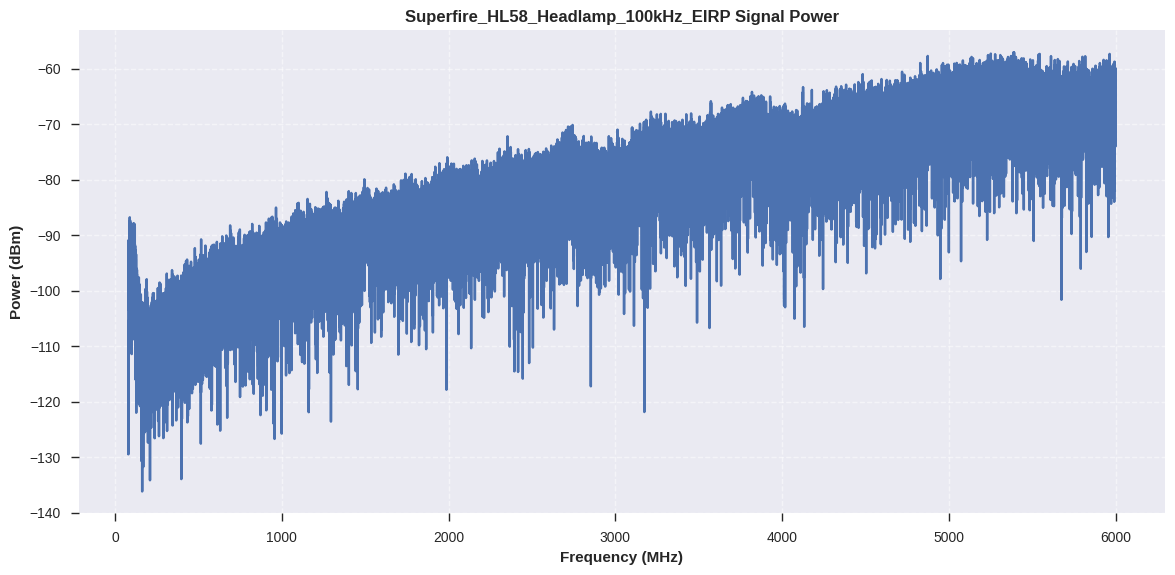

/tmp/ipykernel_4324/74398120.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


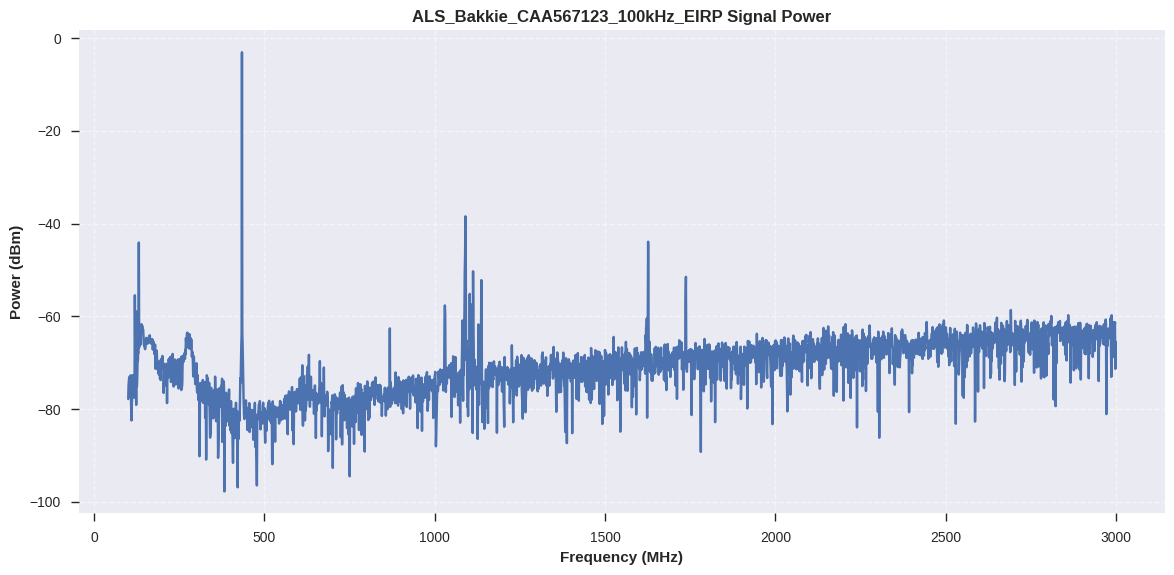

/tmp/ipykernel_4324/74398120.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


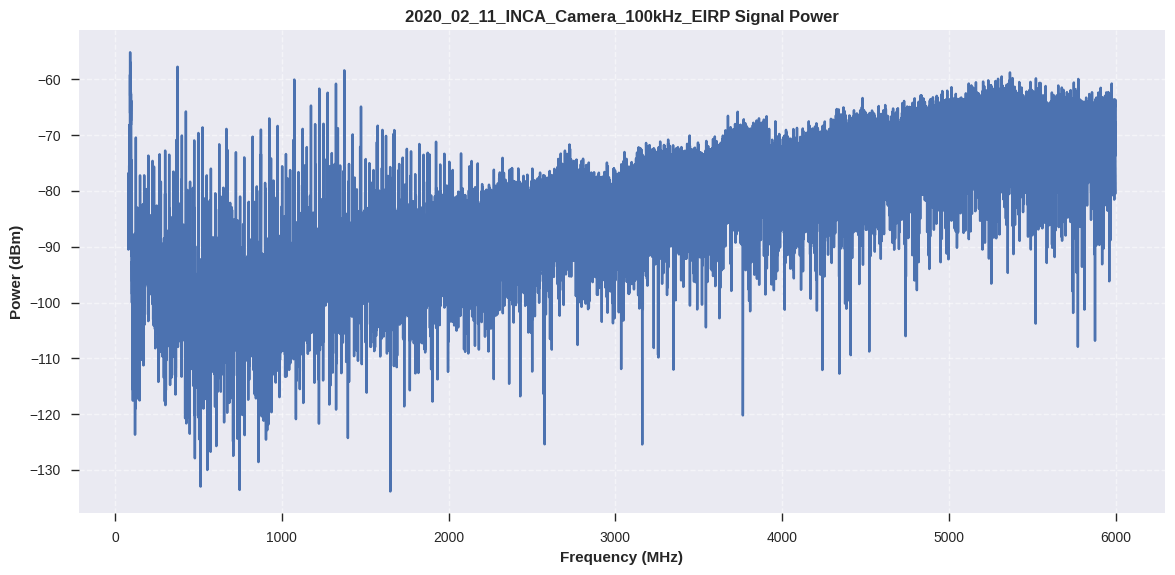

In [5]:
# plot the instrument signal


for instrument_name, df in dataframe_clean.items():
    # Plot settings
    plt.style.use('seaborn')
    plt.figure(figsize=(12, 6))

    
    

    # Plot the instrument PSD
    plt.plot(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'])
    

    plt.title(f'{instrument_name} Signal Power',  fontweight='bold')
    plt.xlabel('Frequency (MHz)', fontweight='bold')
    plt.ylabel('Power (dBm)',fontweight='bold')
    plt.tick_params(axis='both', which='both', direction='out', length=6, width=1)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Determine the best polynomial order for the data

--> To determine the best polynomial order for fitting data (e.g., for detrending), use the Bayesian Information Criterion (BIC) — a standard method for model selection that balances fit quality with model complexity.

In [6]:

def calculate_bic(frequencies, signal, max_degree):
    """
    Calculate BIC values for polynomial fits of varying degrees
    
    Parameters:
    - frequencies: array-like, input frequency values
    - signal: array-like, signal power values
    - max_degree: int, maximum polynomial degree to test 
    
    Returns:
    - bics: list of BIC values for degrees 1..max_degree
    - optimal_degree: degree with minimum BIC
    """
    
    degrees = range(1, max_degree + 1)
    bics = []
    n = len(frequencies)
    
    for deg in degrees:
        # Fit polynomial
        coeffs = np.polyfit(frequencies, signal, deg)
        y_fit = np.polyval(coeffs, frequencies)
        
        # Residual sum of squares
        residuals = signal - y_fit
        rss = np.sum(residuals ** 2)
        
        # BIC calculation
        k = deg + 1  # Number of parameters
        bic = n * np.log(rss / n) + k * np.log(n)
        bics.append(bic)
    
    
    return bics, degrees

/tmp/ipykernel_4324/53655080.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_4324/53655080.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_4324/53655080.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_4324/53655080.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_4324/53655080.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_4324/53655080.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_4324/53655080

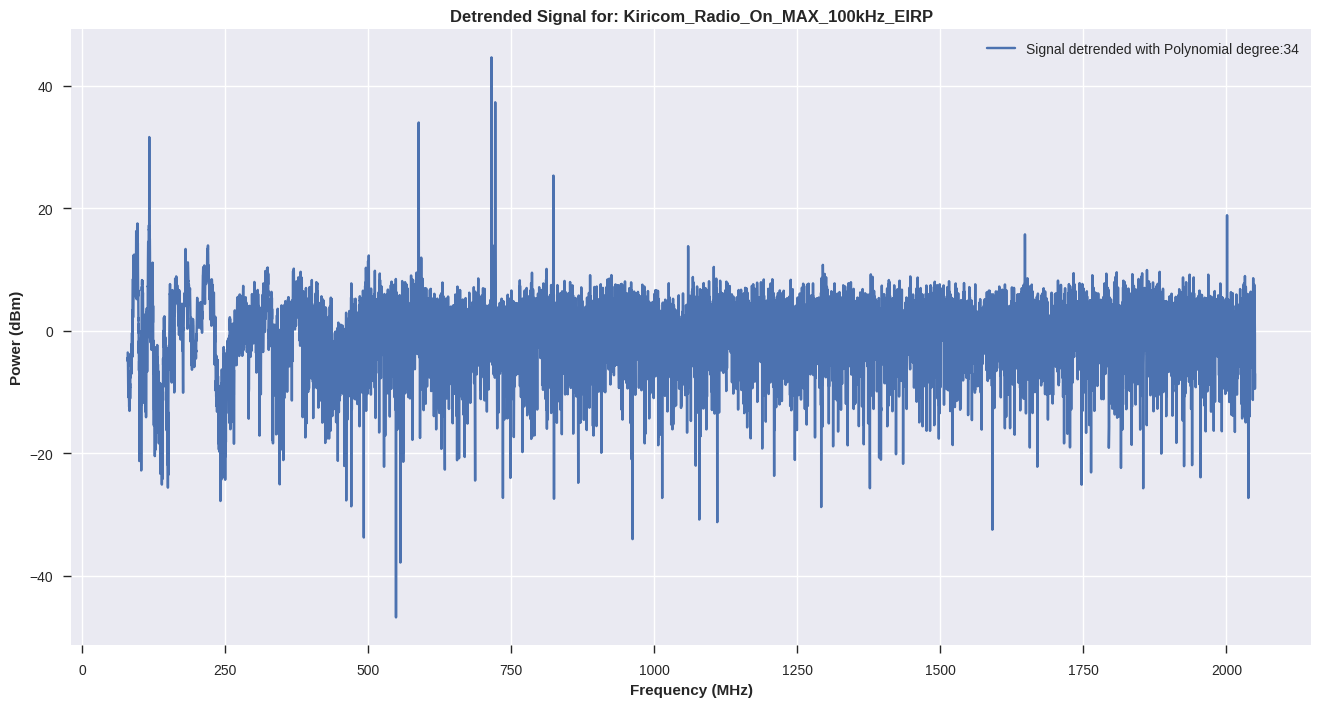

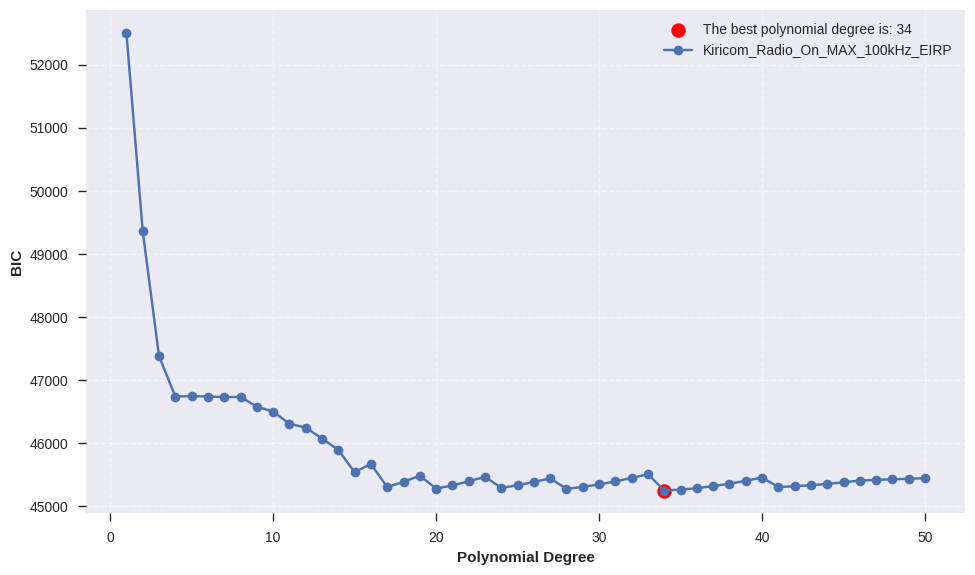

/tmp/ipykernel_4324/53655080.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_4324/53655080.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_4324/53655080.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_4324/53655080.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_4324/53655080.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_4324/53655080.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_4324/53655080

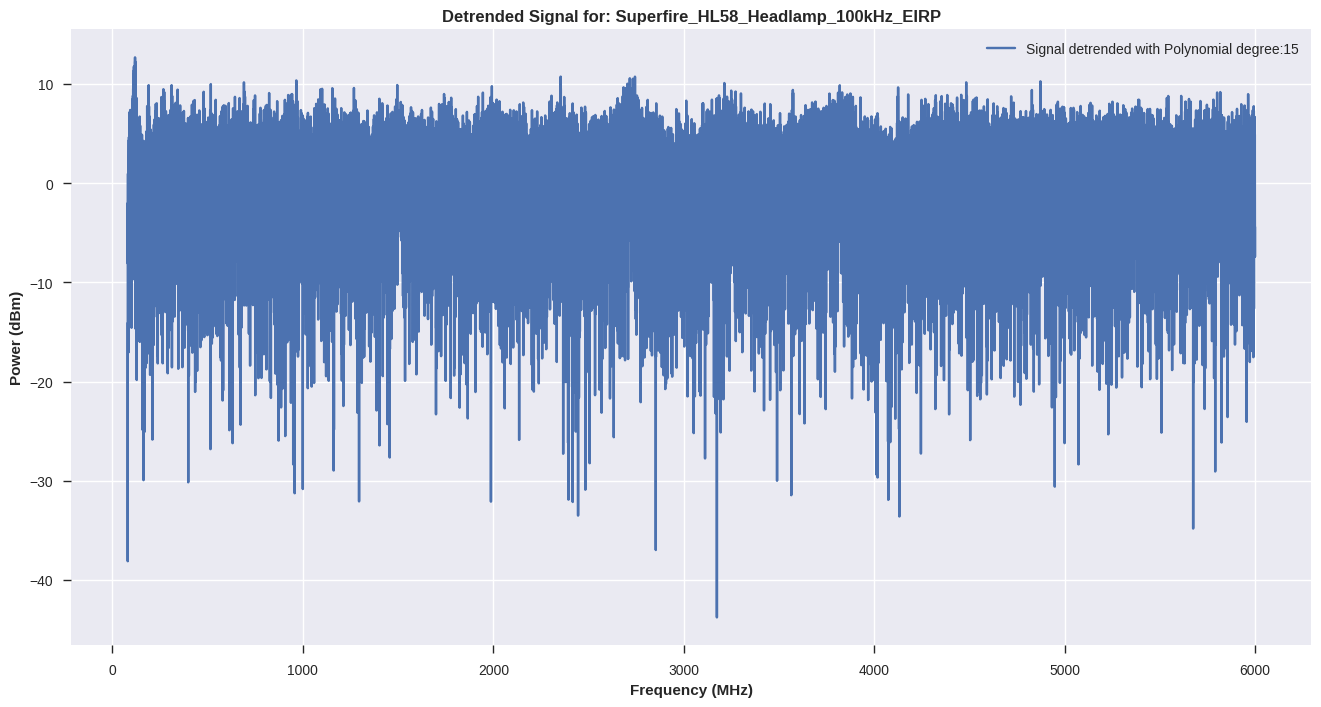

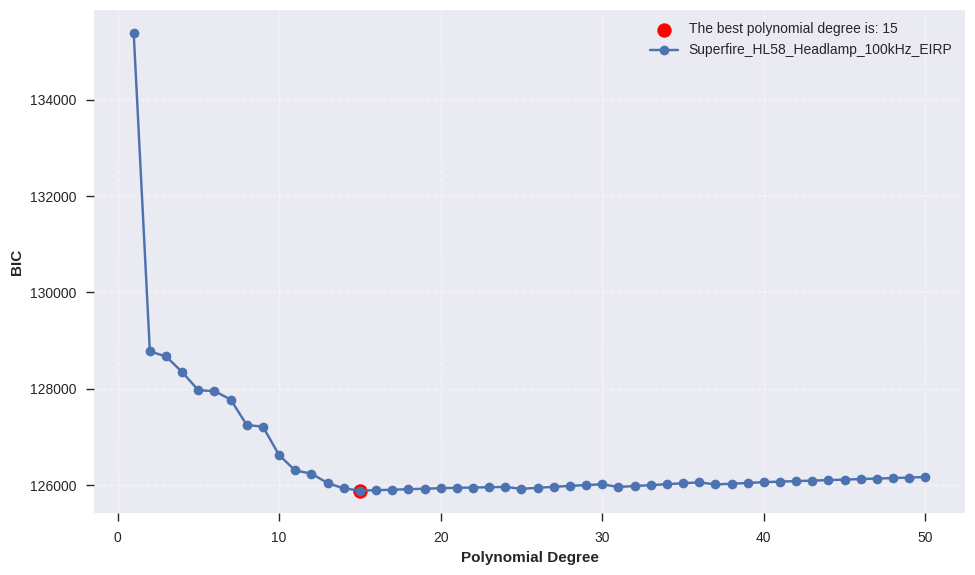

/tmp/ipykernel_4324/53655080.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_4324/53655080.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_4324/53655080.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_4324/53655080.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_4324/53655080.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_4324/53655080.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_4324/53655080

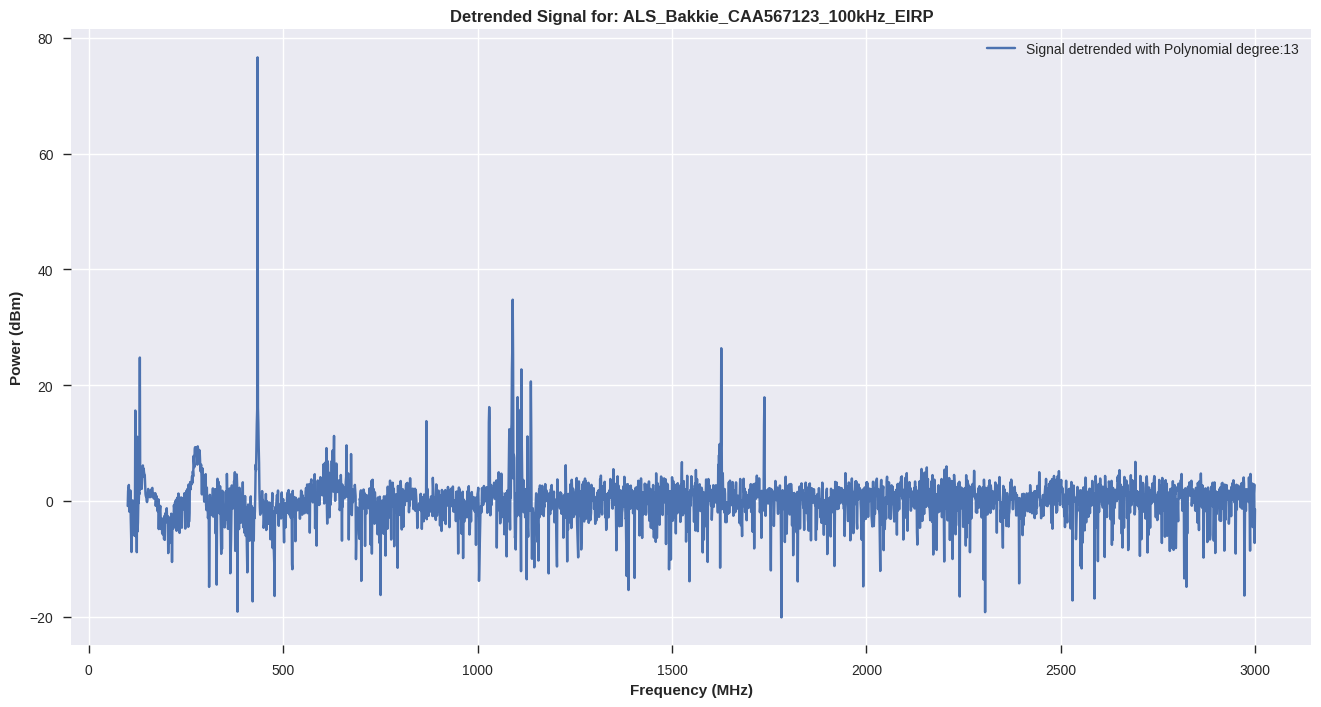

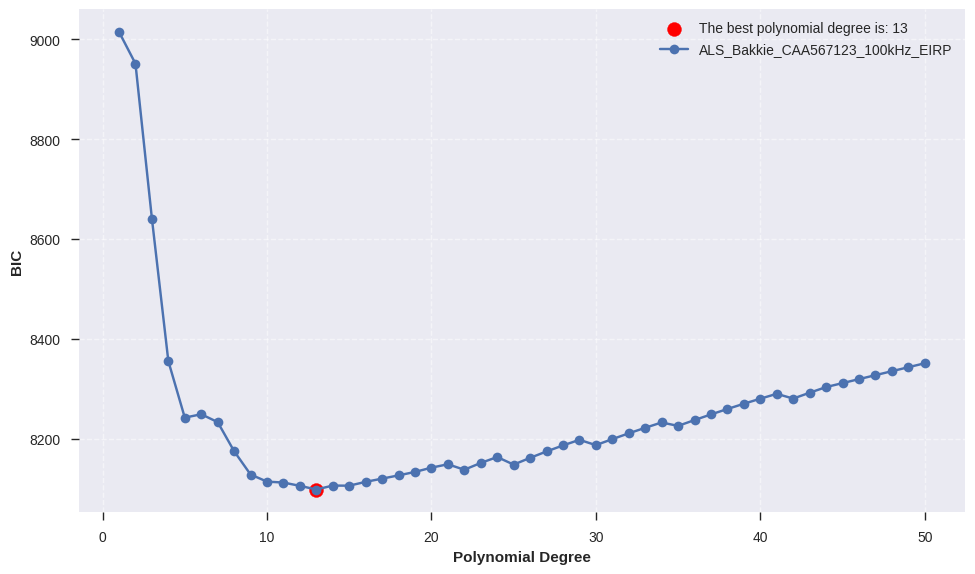

/tmp/ipykernel_4324/53655080.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_4324/53655080.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_4324/53655080.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_4324/53655080.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_4324/53655080.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_4324/53655080.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_4324/53655080

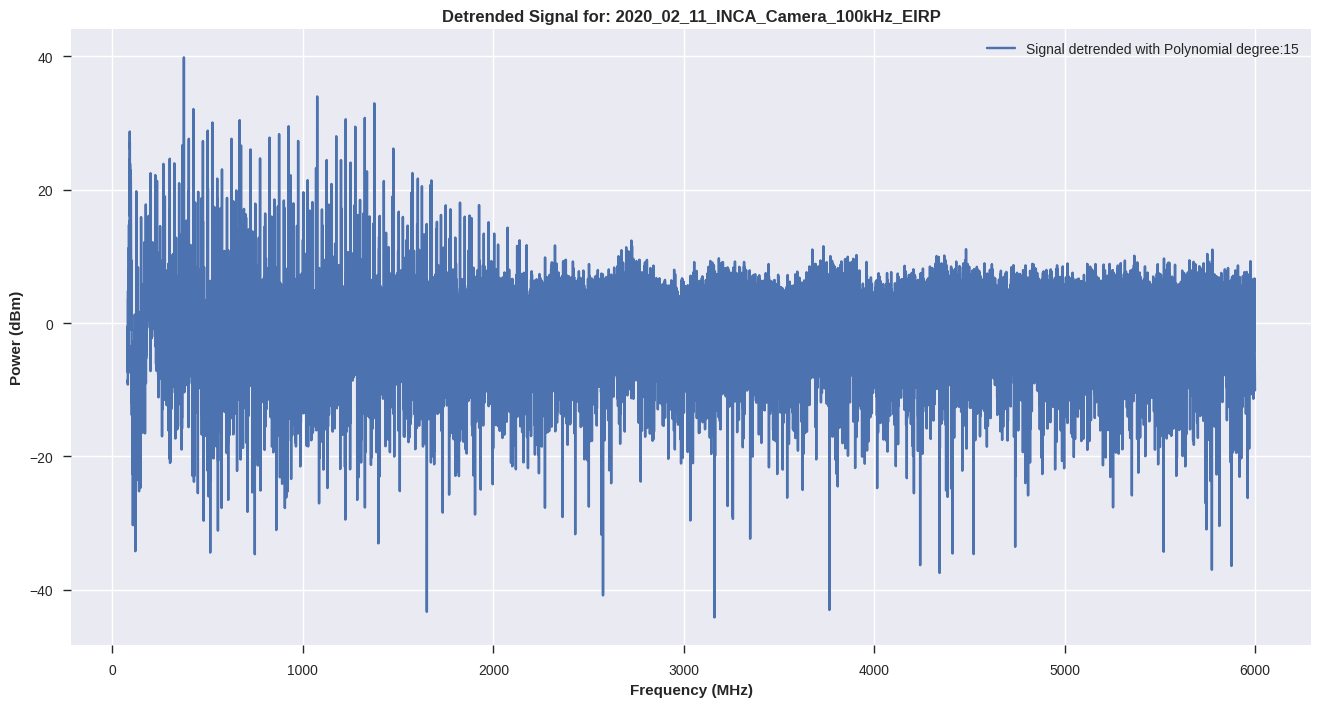

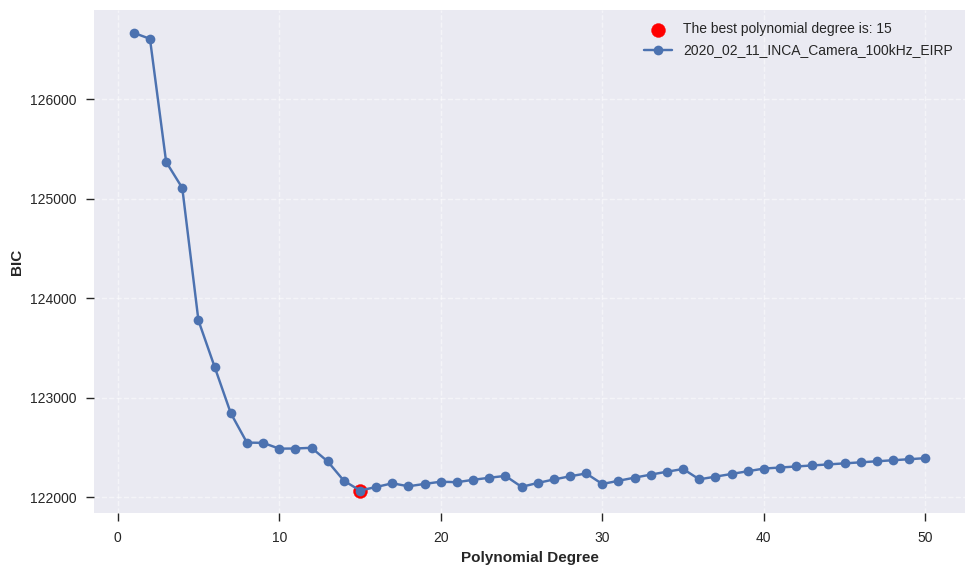

In [7]:
for instrument_name, df in dataframe_clean.items():

    # calculate the bic values
    bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)

    # Find optimal degree
    optimal_idx = np.argmin(bic)
    optimal_degree = degree[optimal_idx]

    ## Perform Polynomial Detrending
    # determine the polynomial coeficients
    trend_pol = np.polyfit(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], degree[optimal_idx])
    # trend values 
    trend_values = np.polyval(trend_pol, df['Frequency (MHz)'])
    # detrend the signal 
    detrend_pol = df['Clean_EIRP(dBm)']-trend_values
    # print(f'The best polynomial degree is: {optimal_degree}')


    
    plt.style.use('seaborn')

    plt.figure(figsize=(16,8))
    plt.plot(df['Frequency (MHz)'], detrend_pol, label='Signal detrended with Polynomial degree:'+str(optimal_degree))
    plt.xlabel('Frequency (MHz)', fontweight='bold')
    plt.ylabel('Power (dBm)', fontweight='bold')
    plt.tick_params(axis='both', which='both', direction='out', length=6, width=1)
    plt.title(f'Detrended Signal for: {instrument_name}', fontweight='bold')
    plt.legend(framealpha=1, facecolor='white')


    plt.figure(figsize=(10,6))
    plt.scatter(degree[optimal_idx], bic[optimal_idx], c='red', marker='o', s=100, label='The best polynomial degree is: '+str(optimal_degree))
    plt.plot(degree, bic, marker='o', label=instrument_name)
    plt.xlabel('Polynomial Degree', fontweight='bold')
    plt.ylabel('BIC', fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tick_params(axis='both', which='both', direction='out', length=6, width=1)
    plt.legend(framealpha=1, facecolor='white')
    plt.tight_layout()
    plt.show()


    

# Identify the peaks.

-- To identify the peaks we will be using the function `find_peanks` from the module `scipy.signal`.

The function has three basic parameter such as:
* height - Minimum height of peaks. Can be a number or tuple (min, max).
* distance - Minimum number of samples between peaks. Useful to avoid detecting nearby noise bumps.
* prominence - Minimum required prominence of peaks. Measures how much a peak stands out from surroundings.


In [8]:
def peaks_detection(signal,h,p,d):
    """
    Parameter:
    signal (array): detrended signal
    h (int): minimum value of the peaks(STD or MAD)
    p (int): how much apeaj stands out form surrounding
    d (int): minimum number os samples between peaks
    
    Retur:
    peaks(array): amplitude of the peaks detetcted
    """

    peak, _ = find_peaks(signal,
                         height=h,
                         prominence=p,
                         distance=d)
    
    return peak

/tmp/ipykernel_4324/3225419288.py:5: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_4324/3225419288.py:5: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_4324/3225419288.py:5: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_4324/3225419288.py:5: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_4324/3225419288.py:5: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_4324/3225419288.py:5: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_4

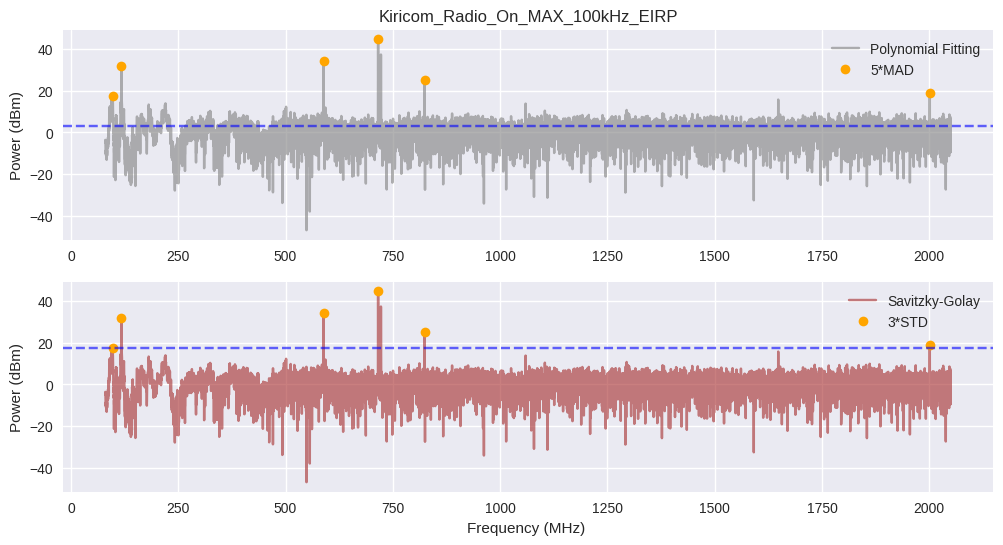

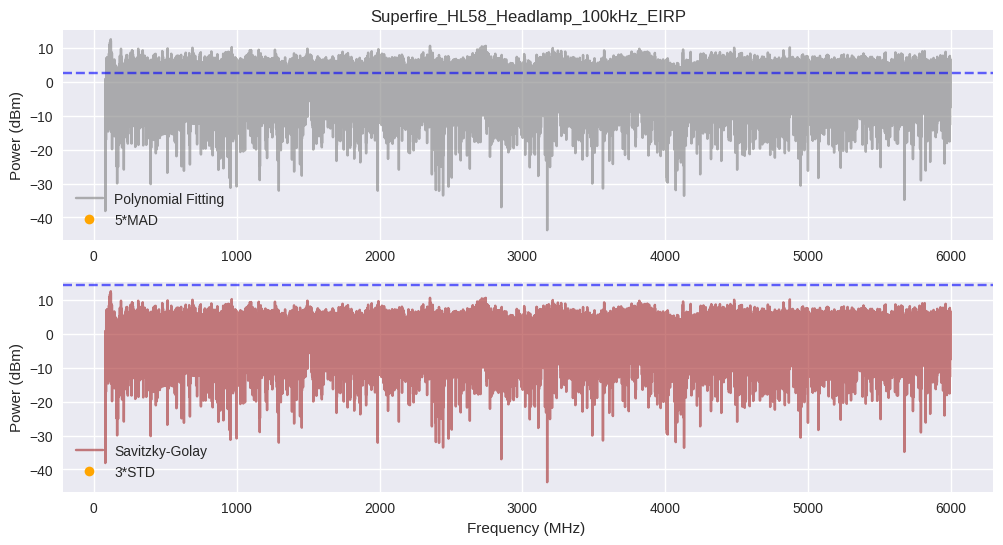

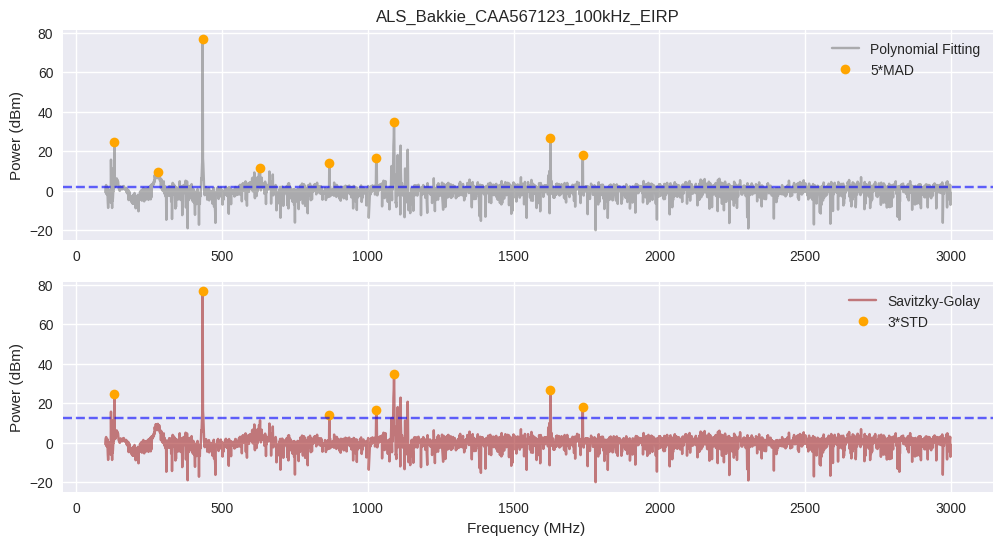

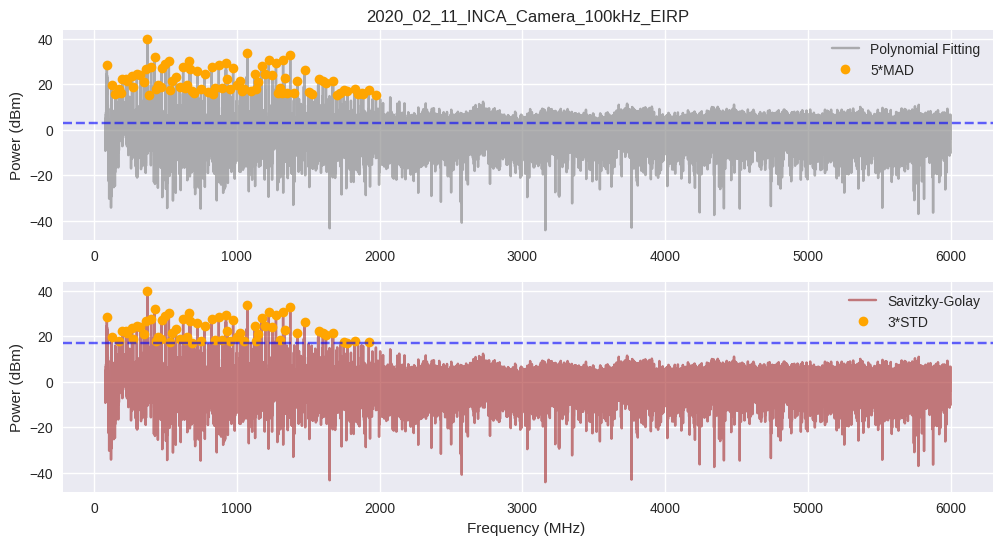

In [9]:

for instrument_name, df in dataframe_clean.items():


    # calculate the bic values
    bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)

    # Find optimal degree
    optimal_idx = np.argmin(bic)
    optimal_degree = degree[optimal_idx]

    ## Perform Polynomial Detrending
    # determine the polynomial coeficients
    trend_pol = np.polyfit(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], degree[optimal_idx])
    # trend values 
    trend_values = np.polyval(trend_pol, df['Frequency (MHz)'])
    # detrend the signal 
    detrend_pol = df['Clean_EIRP(dBm)']-trend_values
    # print(f'The best polynomial degree is: {optimal_degree}')

    
    # findd the peaks
    peaks_pol_MAD, _ = find_peaks(detrend_pol, 
                                height=5*MAD(detrend_pol),
                                prominence=10,
                                distance=50
                                )
    
    peaks_pol_STD, _ = find_peaks(detrend_pol, 
                                height=3*np.std(detrend_pol),
                                prominence=10,
                                distance=50
                                )



    #plot 
    plt.style.use('seaborn')
    fig, axs = plt.subplots(2,1, figsize=(12,6))
    fig.subplots_adjust(hspace=0.2)


    axs[0].plot(df['Frequency (MHz)'], detrend_pol, color='gray', label= 'Polynomial Fitting', alpha=0.6)
    axs[0].plot(df['Frequency (MHz)'].values[peaks_pol_MAD], detrend_pol.values[peaks_pol_MAD], 'o',color='orange', label="5*MAD")
    axs[0].axhline(y=MAD(detrend_pol), alpha=0.6, color='b', linestyle='--')
    axs[0].set_title(instrument_name)
    axs[0].set_ylabel('Power (dBm)')
    axs[0].legend()
    axs[0].grid(True)

    axs[1].plot(df['Frequency (MHz)'], detrend_pol, color='brown', label='Savitzky-Golay', alpha=0.6)
    axs[1].plot(df['Frequency (MHz)'].values[peaks_pol_STD], detrend_pol.values[peaks_pol_STD], 'o', color='orange', label="3*STD")
    axs[1].axhline(y=3*np.std(detrend_pol), alpha=0.6, color='b', linestyle='--')
    axs[1].set_xlabel('Frequency (MHz) ')
    axs[1].set_ylabel('Power (dBm)')
    #axs[1].set_title(instrument_name)
    axs[1].legend()
    axs[1].grid(True)

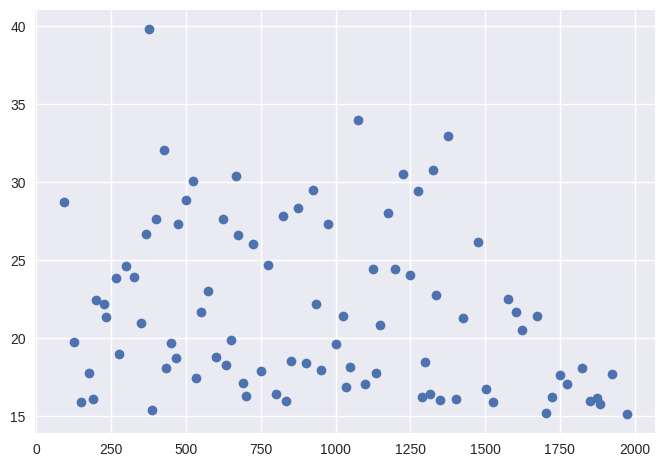

In [10]:
plt.plot(df['Frequency (MHz)'][peaks_pol_MAD], detrend_pol[peaks_pol_MAD], "o")


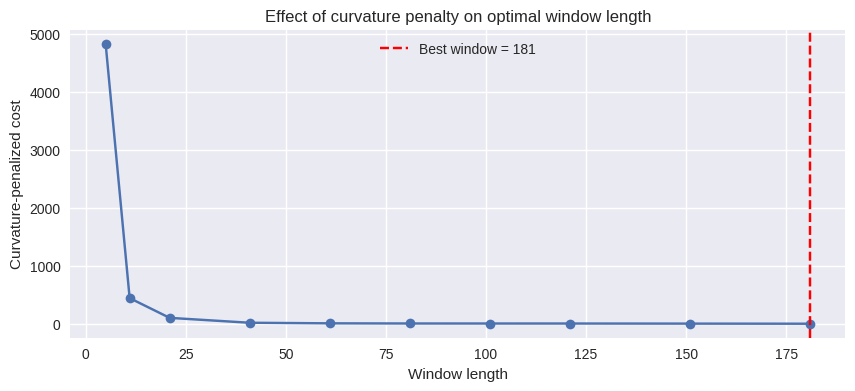

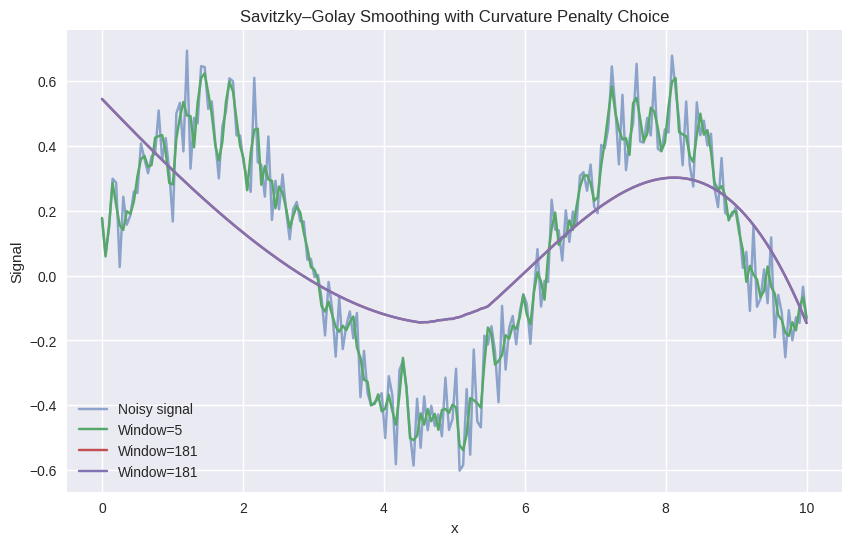

In [11]:
# Example synthetic signal: trend + noise
np.random.seed(0)
x = np.linspace(0, 10, 200)
true_trend = np.sin(x) * 0.5
noise = np.random.normal(0, 0.1, len(x))
signal = true_trend + noise

# Curvature penalty function
def curvature_penalty(x, y, window_length, polyorder):
    trend = savgol_filter(y, window_length=window_length, polyorder=polyorder)
    second_derivative = np.gradient(np.gradient(trend, x), x)
    penalty = np.sum(second_derivative**2)
    residual = np.mean((y - trend)**2)
    return residual + penalty * 0.1  # weighting curvature penalty

# Candidate window lengths
windows = [5, 11, 21, 41, 61, 81, 101, 121, 151, 181]
polyorder = 3

# Compute penalties
penalties = [curvature_penalty(x, signal, w, polyorder) for w in windows]
best_window = windows[np.argmin(penalties)]

# Plot penalty vs window length
plt.figure(figsize=(10,4))
plt.plot(windows, penalties, marker='o')
plt.axvline(best_window, color='red', linestyle='--', label=f"Best window = {best_window}")
plt.xlabel("Window length")
plt.ylabel("Curvature-penalized cost")
plt.title("Effect of curvature penalty on optimal window length")
plt.legend()
plt.grid(True)
plt.show()

# Plot signal smoothing for different windows
plt.figure(figsize=(10,6))
plt.plot(x, signal, label="Noisy signal", alpha=0.6)

for w in [windows[0], best_window, windows[-1]]:
    smoothed = savgol_filter(signal, window_length=w, polyorder=polyorder)
    plt.plot(x, smoothed, label=f"Window={w}")

plt.xlabel("x")
plt.ylabel("Signal")
plt.title("Savitzky–Golay Smoothing with Curvature Penalty Choice")
plt.legend()
plt.grid(True)
plt.show()